## How much high can we go (in terms of number of qubits)

In [35]:
# My functions
from PhaseEstimation import hamiltonians as H
from PhaseEstimation import annni_model as ANNNI
from PhaseEstimation import general as qmlgen
from PhaseEstimation import vqe

# Plotting
import matplotlib.pyplot as plt
from matplotlib import colors
import plotly.graph_objects as go

# Others
import numpy as np, jax.numpy as jnp
import jax
import copy, sys, os

import pennylane as qml
from jax import vmap, jit
from numpy.typing import NDArray

#### Exact Diagonalization

In [5]:
size_unit = 32 # bits

def bits_to_gigabyte(bits):
    return bits * 1.25e-10

In [7]:
sizes_GB_ex = []
Ns = np.arange(8,15)

for N in Ns:
    try:
        Hs  = H.hamiltonian(ANNNI.build_Hs, N = N, n_hs = 1, n_kappas = 1)
        Ham, e, psi = qmlgen.get_H_eigval_eigvec(Hs.qml_Hs[0], 0)
        memory_of_matrix = bits_to_gigabyte(size_unit * Ham.shape[0] * Ham.shape[1])
        sizes_GB_ex.append(memory_of_matrix)
        print(f'______________\n N   = {N}\n MEM = {memory_of_matrix:.4f}')
        del(Hs); del(Ham); del(e); del(psi)
    except:
        print('This is the limit of my computer')

______________
 N   = 8
 MEM = 0.0003
______________
 N   = 9
 MEM = 0.0010
______________
 N   = 10
 MEM = 0.0042
______________
 N   = 11
 MEM = 0.0168
______________
 N   = 12
 MEM = 0.0671
______________
 N   = 13
 MEM = 0.2684
This is the limit of my computer


2023-06-20 12:47:13.499967: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.00GiB (rounded to 4295819776)requested by op 
2023-06-20 12:47:13.500082: W external/tsl/tsl/framework/bfc_allocator.cc:497] ****************************************************________________________________________________
2023-06-20 12:47:13.500217: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2461] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 4295819524 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.00GiB
              constant allocation:         0B
        maybe_live_out allocation:    1.00GiB
     preallocated temp allocation:    4.00GiB
                 total allocation:    6.00GiB
              total fragmentation:       236B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 3.00GiB
		Operator: op_name="jit(linalgeigh)/jit(main)/jit(eigh)

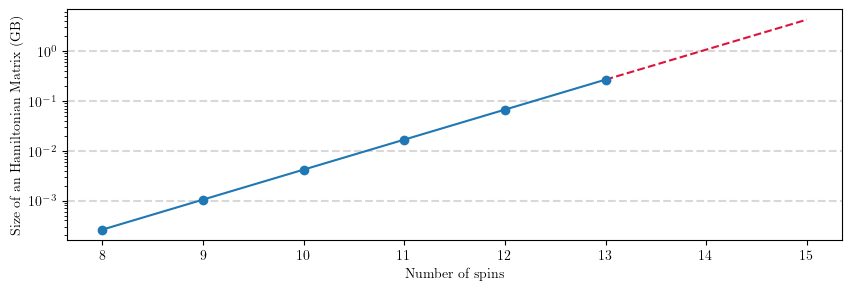

In [33]:
sizes_GB_true = []
Ns_true = range(Ns[:len(sizes_GB_ex)][-1], Ns[-1] + 2)
for N in Ns_true:
    gigabytes = bits_to_gigabyte(size_unit * (2**(2*N)) )
    sizes_GB_true.append(gigabytes)

plt.figure(figsize=(10,3)); plt.xlabel('Number of spins'); plt.ylabel('Size of an Hamiltonian Matrix (GB)')

for y in np.logspace(-3,0,4):
    plt.axhline(y = y, color='gray', ls = '--', alpha=.3)
plt.plot(Ns_true, sizes_GB_true, color = 'crimson', ls = '--')
plt.plot(Ns[:len(sizes_GB_ex)], sizes_GB_ex, marker = 'o')
plt.yscale('log')

In [55]:
def get_H(N, L, K, J1 : float = 1., ring : bool = False) -> NDArray:
    # Interaction of spins with magnetic field
    H = L * qml.PauliZ(0)
    for i in range(1, N):
        H = H + (L * qml.PauliZ(i))

    # Interaction between spins (neighbouring):
    for i in range(0, N - 1):
        H = H + (qml.PauliX(i) @ qml.PauliX(i + 1))

    # Interaction between spins (next-neighbouring):
    for i in range(0, N - 2):
        H = H + (K * (qml.PauliX(i) @ qml.PauliX(i + 2)))

    # If ring == True, the 'chain' needs to be closed
    if ring:
        # Nearest interaction between last spin and first spin -particles
        H = H + (qml.PauliX(N - 1) @ qml.PauliX(0))
        # Next nearest interactions:
        H = H + (K * (qml.PauliX(N - 1) @ qml.PauliX(1)))
        H = H + (K * (qml.PauliX(N - 2) @ qml.PauliX(0)))

    H = -J1 * H

    return jnp.array(qml.matrix(H))

def get_eigs(H : NDArray, max_e_lvl : int = 0):
    eigvals, eigvecs = jnp.linalg.eigh(H)
    
    return eigvals[: max_e_lvl+1], eigvecs[: , : max_e_lvl+1]

v_get_eigs = (vmap(get_eigs, (0, None)))

In [73]:
Ns = np.arange(4,12,2)
EVALS = []
for N in Ns:
    L   = .5
    n_k = 100
    kappas = np.linspace(0,-1,n_k)

    Hs = []
    for k in kappas:
        Hs.append(get_H(N, L, k, ring=False))

    Hs = jnp.array(Hs)

    evals, _ = v_get_eigs(Hs,0)

    EVALS.append(evals.flatten())

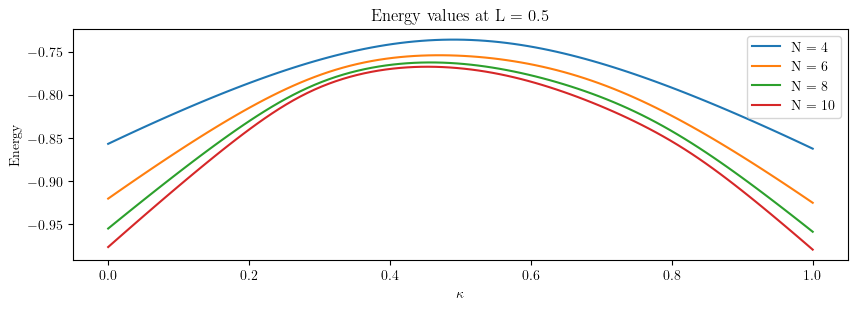

In [74]:
plt.figure(figsize=(10,3))
for eval, N in zip(EVALS, Ns):
    plt.plot(-kappas, eval/N, label=f'N = {N}')

plt.title(f'Energy values at L = {L}')
plt.xlabel(r'$\kappa$'); plt.ylabel('Energy'); plt.legend()

/home/saverio/anaconda3/envs/annni2/lib/python3.10/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/saverio/anaconda3/envs/annni2/lib/python3.10/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


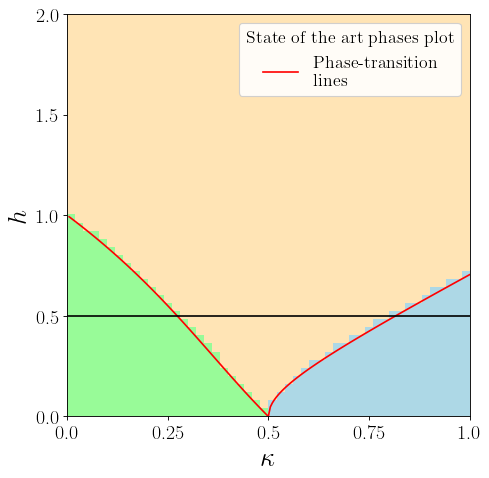

In [75]:
Hs = H.hamiltonian(ANNNI.build_Hs, N = 1, n_hs = 50, n_kappas = 50, kappa_max=1, ring = False)
Hs.show_phasesplot()
plt.axhline(.755*(50-1), color='black')

In [1]:
import qcnn_test as qcnn
import pennylane as qml
import numpy as np


/home/saverio/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
for N in range(15,30):
    print(N)
    toymodel = qcnn.qcnn(N, qcnn.qcnn_circuit)
    toymodel.train(10)
    del(toymodel)

15


100%|██████████| 10/10 [00:22<00:00,  2.21s/it]


16


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


17


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]


18


100%|██████████| 10/10 [00:30<00:00,  3.06s/it]


19


100%|██████████| 10/10 [00:33<00:00,  3.31s/it]


20


100%|██████████| 10/10 [00:44<00:00,  4.48s/it]


21


100%|██████████| 10/10 [00:45<00:00,  4.52s/it]


22


  0%|          | 0/10 [00:00<?, ?it/s]2023-06-20 17:45:44.936667: W external/xla/xla/service/hlo_rematerialization.cc:2218] Can't reduce memory use below 5.84GiB (6270763008 bytes) by rematerialization; only reduced to 6.03GiB (6475965816 bytes)
2023-06-20 17:46:15.164490: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.00GiB (rounded to 6442487296)requested by op 
2023-06-20 17:46:15.164664: W external/tsl/tsl/framework/bfc_allocator.cc:497] *___________________________________________________________________________________________________
2023-06-20 17:46:15.183970: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2461] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 6442487152 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:       620B
              constant allocation:   64.00MiB
        maybe_live_out allocation:       62

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 6442487152 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:       620B
              constant allocation:   64.00MiB
        maybe_live_out allocation:       620B
     preallocated temp allocation:    6.00GiB
  preallocated temp fragmentation:    17.3KiB (0.00%)
                 total allocation:    6.06GiB
              total fragmentation:   64.03MiB (1.03%)
Peak buffers:
	Buffer 1:
		Size: 32.00MiB
		XLA Label: fusion
		Shape: c64[2097152,2]
		==========================

	Buffer 2:
		Size: 32.00MiB
		XLA Label: fusion
		Shape: c64[2097152,2]
		==========================

	Buffer 3:
		Size: 32.00MiB
		XLA Label: fusion
		Shape: c64[2097152,2]
		==========================

	Buffer 4:
		Size: 32.00MiB
		XLA Label: fusion
		Shape: c64[2097152,2]
		==========================

	Buffer 5:
		Size: 32.00MiB
		XLA Label: fusion
		Shape: c64[2097152,2]
		==========================

	Buffer 6:
		Size: 32.00MiB
		XLA Label: fusion
		Shape: c64[2097152,2]
		==========================

	Buffer 7:
		Size: 32.00MiB
		XLA Label: fusion
		Shape: c64[2097152,2]
		==========================

	Buffer 8:
		Size: 32.00MiB
		XLA Label: fusion
		Shape: c64[2097152,2]
		==========================

	Buffer 9:
		Size: 32.00MiB
		XLA Label: fusion
		Shape: c64[2097152,2]
		==========================

	Buffer 10:
		Size: 32.00MiB
		XLA Label: fusion
		Shape: c64[2097152,2]
		==========================

	Buffer 11:
		Size: 32.00MiB
		XLA Label: fusion
		Shape: c64[2097152,2]
		==========================

	Buffer 12:
		Size: 32.00MiB
		XLA Label: fusion
		Shape: c64[2097152,2]
		==========================

	Buffer 13:
		Size: 32.00MiB
		XLA Label: fusion
		Shape: c64[2097152,2]
		==========================

	Buffer 14:
		Size: 32.00MiB
		XLA Label: constant
		Shape: c64[2097152,2]
		==========================

	Buffer 15:
		Size: 32.00MiB
		XLA Label: constant
		Shape: c64[2,2097152]
		==========================

